In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from pylab import rcParams
from sklearn.model_selection import train_test_split as split
import warnings
import itertools
warnings.filterwarnings("ignore")
#from fbprophet import Prophet
from IPython import display
from matplotlib import pyplot
import os
import re
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch
import yfinance as yf

In [3]:
data = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


In [4]:
data['Date'] = pd.to_datetime(data.index, infer_datetime_format=True)


In [5]:
data = data[["Date", "Open", "High", "Low", "Adj Close", "Volume"]]

In [6]:
data_feature_selected = data.drop(axis=1, labels=["Open", "High", "Low", "Volume"])

In [7]:
from matplotlib import pyplot

<Axes: xlabel='Date'>

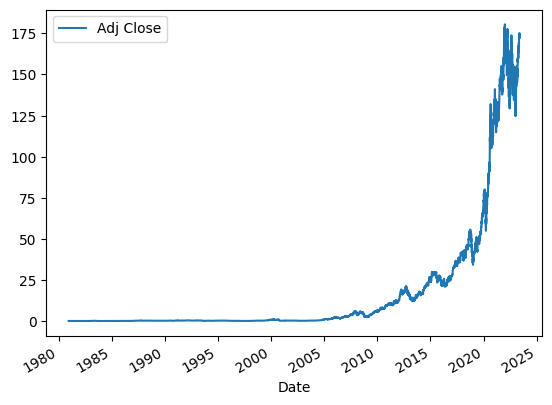

In [8]:
data_feature_selected.plot(y="Adj Close", use_index="True")

In [9]:
data_feature_selected['differenced_trasnformation_demand'] = data_feature_selected['Adj Close'].diff().values
data_feature_selected.head()

,Date,Adj Close,differenced_trasnformation_demand
Date,,,
1980-12-12,1980-12-12,0.099584,NaN
1980-12-15,1980-12-15,0.094388,-0.005195
1980-12-16,1980-12-16,0.087461,-0.006928
1980-12-17,1980-12-17,0.089625,0.002165
1980-12-18,1980-12-18,0.092224,0.002598


In [10]:
data_feature_selected['differenced_demand_filled'] = np.where(pd.isnull(data_feature_selected['differenced_trasnformation_demand']), data_feature_selected['Adj Close'], data_feature_selected['differenced_trasnformation_demand'])
data_feature_selected.head()

,Date,Adj Close,differenced_trasnformation_demand,differenced_demand_filled
Date,,,,
1980-12-12,1980-12-12,0.099584,NaN,0.099584
1980-12-15,1980-12-15,0.094388,-0.005195,-0.005195
1980-12-16,1980-12-16,0.087461,-0.006928,-0.006928
1980-12-17,1980-12-17,0.089625,0.002165,0.002165
1980-12-18,1980-12-18,0.092224,0.002598,0.002598


In [11]:
data_feature_selected['differenced_inv_transformation_demand'] = data_feature_selected['differenced_demand_filled'].cumsum()
np.testing.assert_array_equal(data_feature_selected['Adj Close'].values, data_feature_selected['differenced_inv_transformation_demand'].values)
     

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
FIGURE_SIZE = (20, 10)
plt.rcParams['axes.grid'] = True

%matplotlib inline

<Axes: xlabel='Date'>

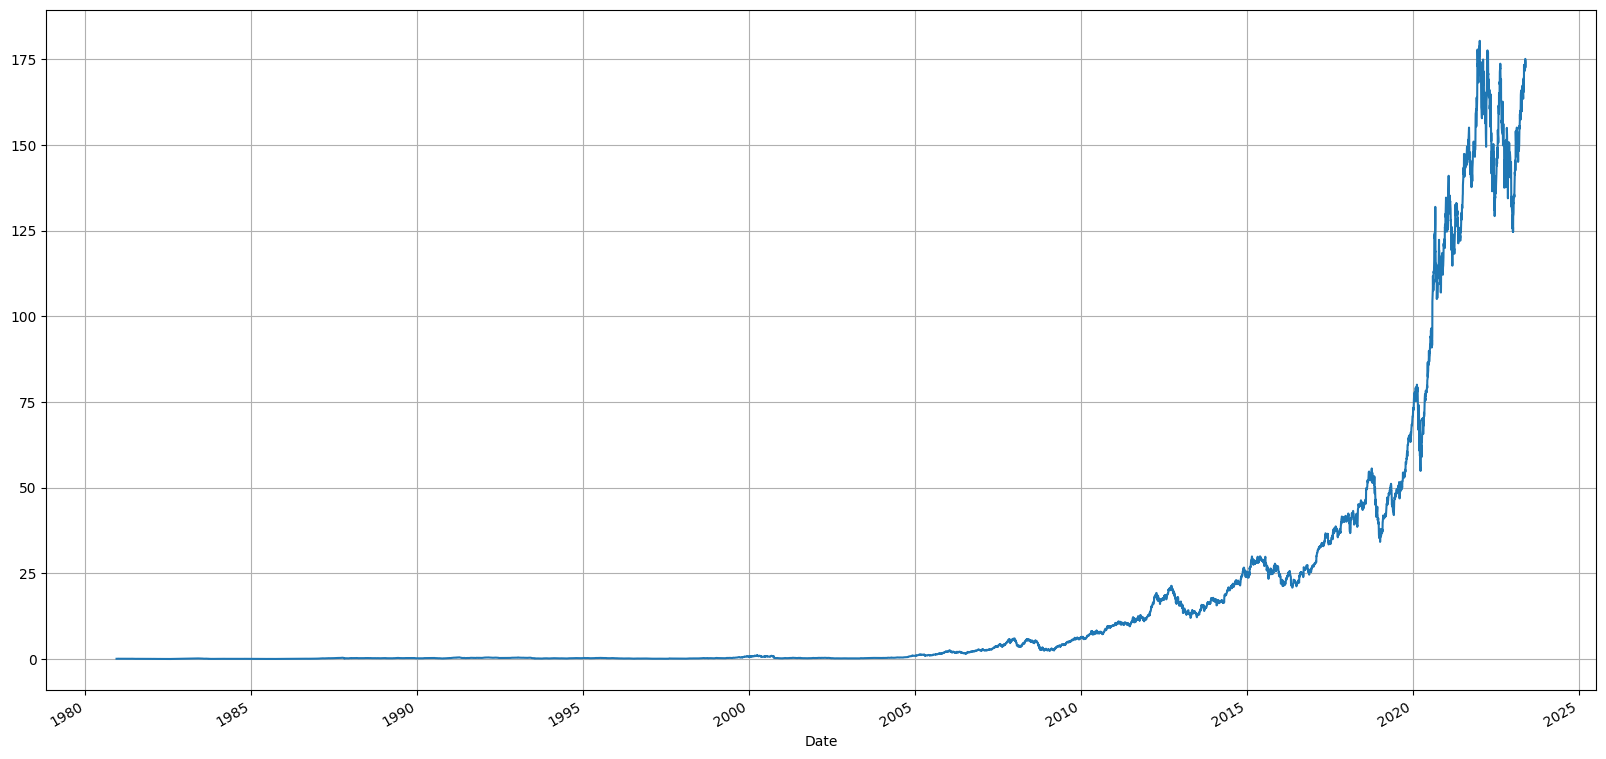

In [14]:
data.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

<Axes: xlabel='Date'>

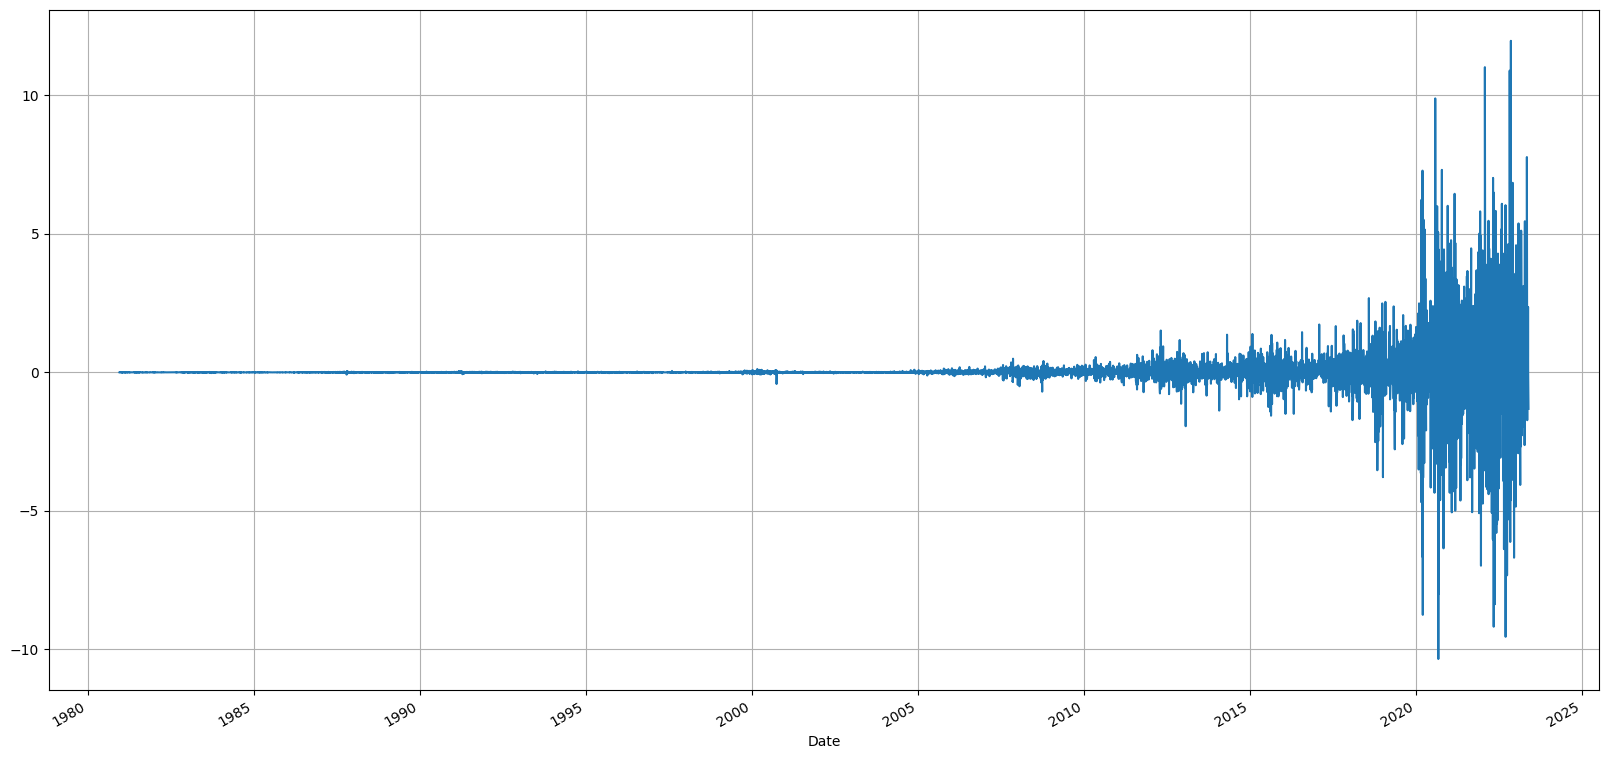

In [15]:
data_feature_selected.set_index('Date')['differenced_trasnformation_demand'].plot(figsize=FIGURE_SIZE)

<Axes: xlabel='Date'>

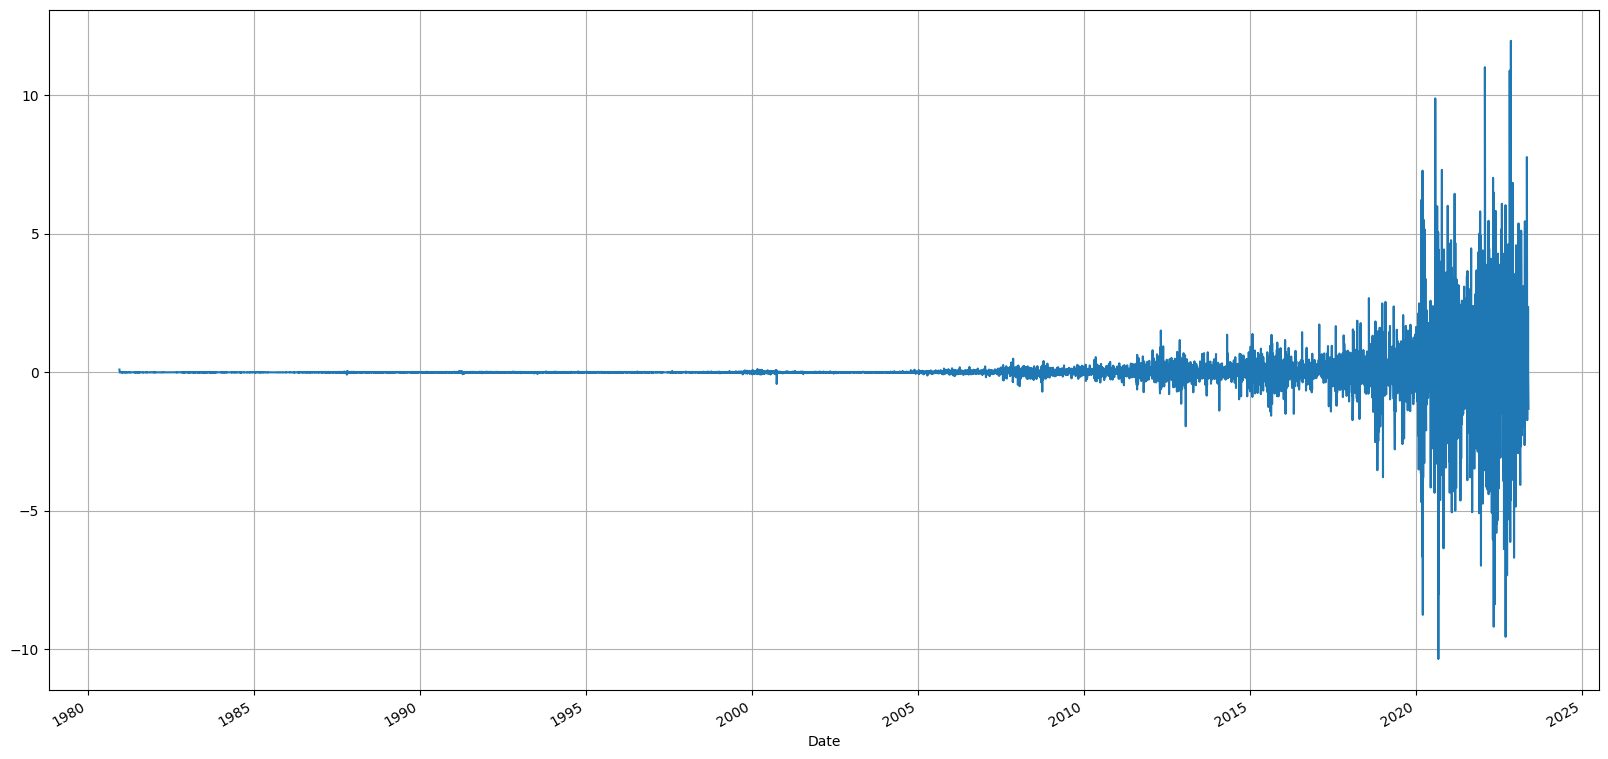

In [16]:
data_feature_selected.set_index('Date')['differenced_demand_filled'].plot(figsize=FIGURE_SIZE)

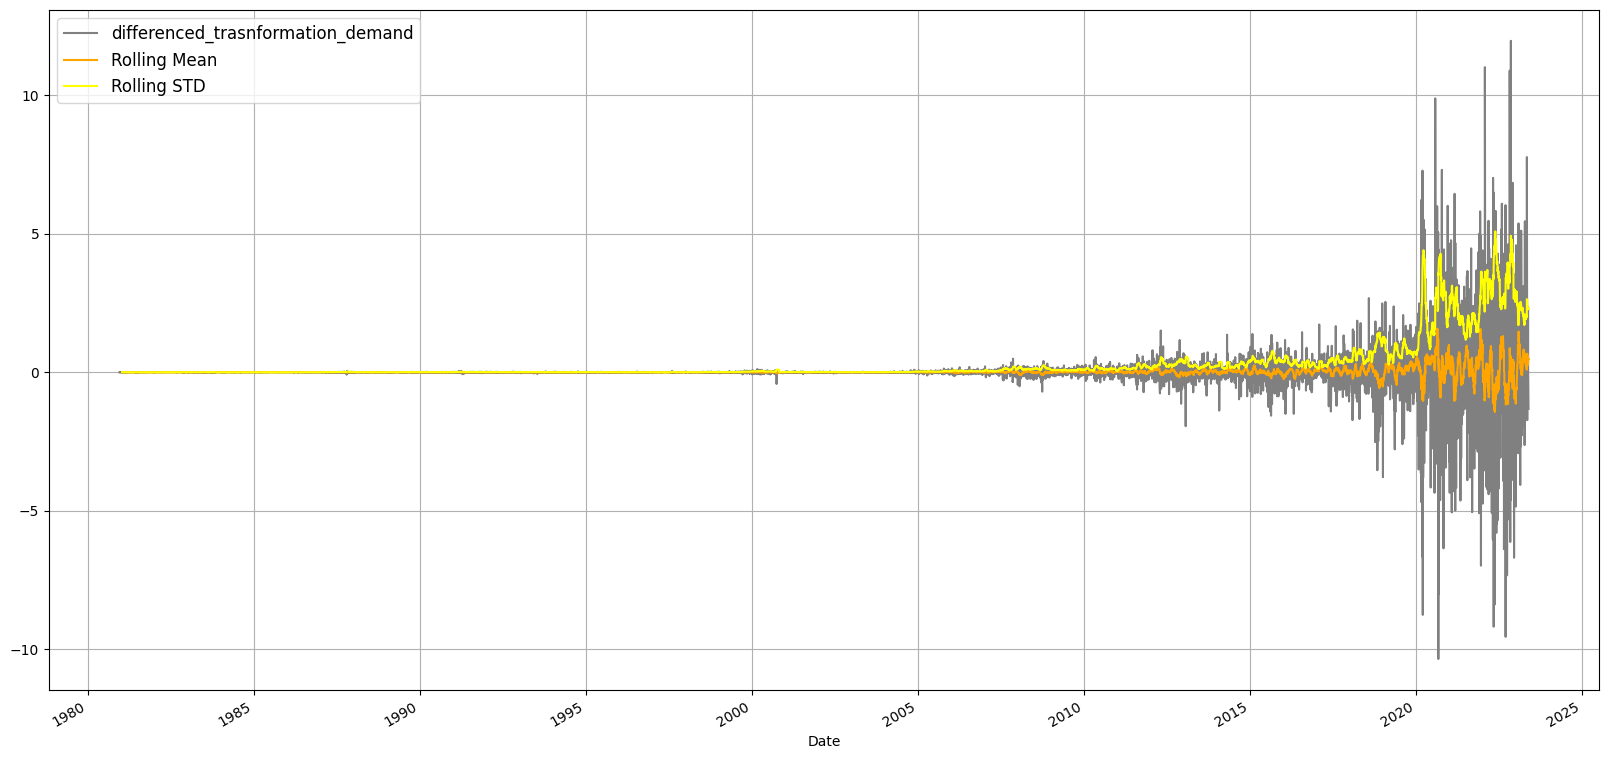

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
data_feature_selected['differenced_trasnformation_demand'][1:].plot(c='grey')
data_feature_selected['differenced_trasnformation_demand'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
data_feature_selected['differenced_trasnformation_demand'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

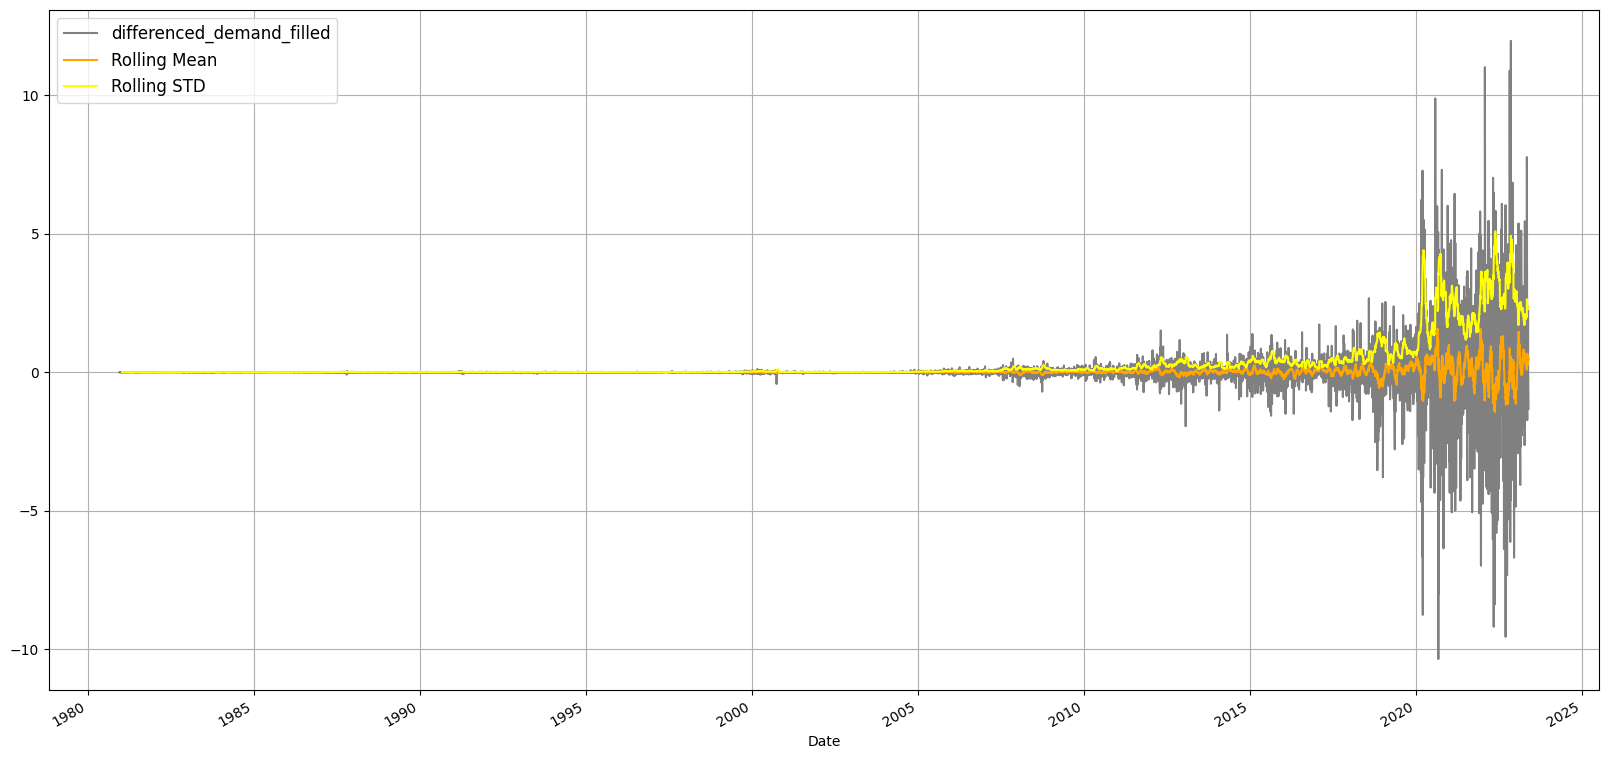

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
data_feature_selected['differenced_demand_filled'][1:].plot(c='grey')
data_feature_selected['differenced_demand_filled'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
data_feature_selected['differenced_demand_filled'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [19]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data_feature_selected['differenced_demand_filled'])

KPSS Statistic: 1.0510170813330866
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [20]:
def build_temporal_features(data: pd.DataFrame) -> pd.DataFrame:
    # Temporal features
    data_feature_selected['date'] = pd.to_datetime(data['Date'])
    data_feature_selected['year'] = data_feature_selected['Date'].dt.year
    data_feature_selected['month'] = data_feature_selected['Date'].dt.month
    #data_feature_selected['week'] = data_feature_selected['Date'].dt.week
    data_feature_selected['day'] = data_feature_selected['Date'].dt.day
    data_feature_selected['dayofweek'] = data_feature_selected['Date'].dt.dayofweek
    #data['quarter'] = data['date'].dt.quarter
    data_feature_selected['week_of_month'] = data['day'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    data_feature_selected['is_weekend'] = (data_feature_selected['dayofweek'] > 5).astype(np.int8)
    
    return data_feature_selected

In [21]:
df1 = build_temporal_features(data_feature_selected)
df1.head()

,Date,Adj Close,differenced_trasnformation_demand,differenced_demand_filled,differenced_inv_transformation_demand,date,year,month,day,dayofweek,week_of_month,is_weekend
Date,,,,,,,,,,,,
1980-12-12,1980-12-12,0.099584,NaN,0.099584,0.099584,1980-12-12,1980,12,12,4,2,0
1980-12-15,1980-12-15,0.094388,-0.005195,-0.005195,0.094388,1980-12-15,1980,12,15,0,3,0
1980-12-16,1980-12-16,0.087461,-0.006928,-0.006928,0.087461,1980-12-16,1980,12,16,1,3,0
1980-12-17,1980-12-17,0.089625,0.002165,0.002165,0.089625,1980-12-17,1980,12,17,2,3,0
1980-12-18,1980-12-18,0.092224,0.002598,0.002598,0.092224,1980-12-18,1980,12,18,3,3,0


In [22]:
df1[df1.is_weekend == 1]

,Date,Adj Close,differenced_trasnformation_demand,differenced_demand_filled,differenced_inv_transformation_demand,date,year,month,day,dayofweek,week_of_month,is_weekend
Date,,,,,,,,,,,,


(array([0. , 0.5, 1. , 1.5, 2. , 2.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

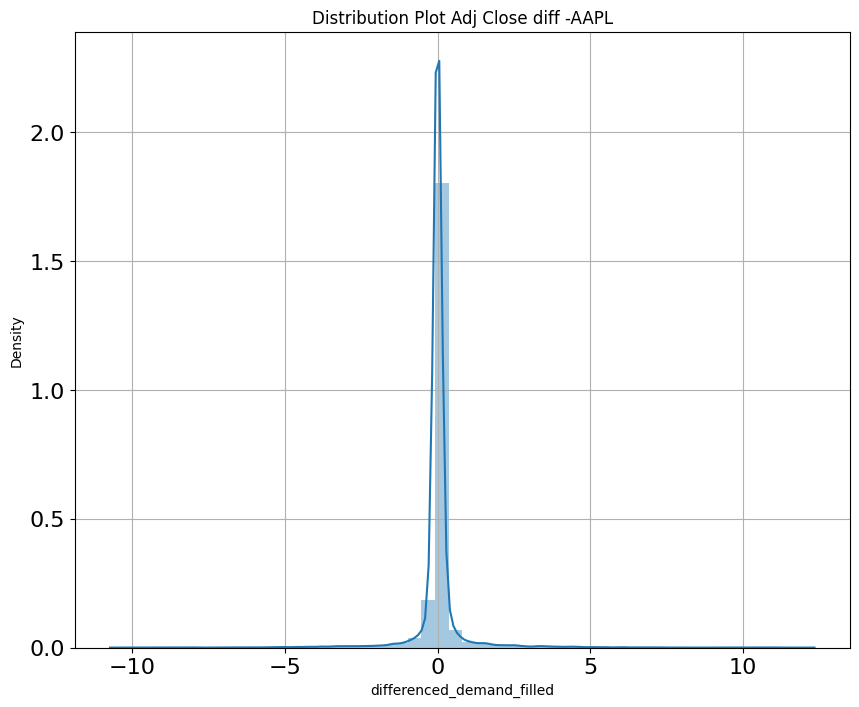

In [23]:
fig = plt.figure(figsize=(10,8))
sns.distplot(df1['differenced_demand_filled']).set_title("Distribution Plot Adj Close diff -AAPL")
#ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [24]:
current_datetime = datetime.now()

# Extract the date portion
current_date = current_datetime.date()

# Convert the date to a string
current_date_string = current_date.strftime('%Y-%m-%d')

In [25]:
y = df1['Adj Close']

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [27]:
##splitting dataset into train and test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [28]:
training_size,test_size

(6955, 3746)

In [29]:
train_data[2]


array([0.00027361])

In [30]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [31]:
import numpy

In [32]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [33]:
print(X_train.shape), print(y_train.shape)

(6854, 100)
(6854,)


(None, None)

In [34]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [35]:
import tensorflow

In [36]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout ,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.initializers import RandomNormal, Constant

In [37]:


# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(150))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [38]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 150)          91200     
                                                                 
 dropout (Dropout)           (None, 100, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          180600    
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0

In [39]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [41]:
import tensorflow as tf

In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [43]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
monitor = EarlyStopping(monitor='val_loss', min_delta=2e-3, patience=300, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(X_train,y_train,validation_data=(X_test,ytest),
        callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
215/215 [==============================] - 5s 24ms/step - loss: 4.3127e-05 - val_loss: 0.0390
Epoch 2/1000
215/215 [==============================] - 5s 21ms/step - loss: 1.8562e-06 - val_loss: 0.0263
Epoch 3/1000
215/215 [==============================] - 5s 22ms/step - loss: 1.0016e-06 - val_loss: 0.0255
Epoch 4/1000
215/215 [==============================] - 5s 22ms/step - loss: 1.0067e-06 - val_loss: 0.0210
Epoch 5/1000
215/215 [==============================] - 5s 21ms/step - loss: 9.4478e-07 - val_loss: 0.0248
Epoch 6/1000
215/215 [==============================] - 5s 24ms/step - loss: 9.1977e-07 - val_loss: 0.0220
Epoch 7/1000
215/215 [==============================] - 5s 21ms/step - loss: 7.9094e-07 - val_loss: 0.0190
Epoch 8/1000
215/215 [==============================] - 5s 22ms/step - loss: 8.4949e-07 - val_loss: 0.0199
Epoch 9/1000
215/215 [==============================] - 5s 23ms/step - loss: 7.4974e-07 - val_loss: 0.0224
Epoch 10/1000
215/215 [==============

In [49]:
model.save("lstm_1000epoch_mayukh.h5")